In [1]:
import shapefile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import sklearn
import datetime
from shapely.geometry import Polygon, Point, MultiPolygon
import random
import time
import joblib

In [2]:
sf = shapefile.Reader("SHP_ETRS89/DISTRITOS")
sf.shapeType

5

In [3]:
shapes = sf.shapes()
len(shapes)

21

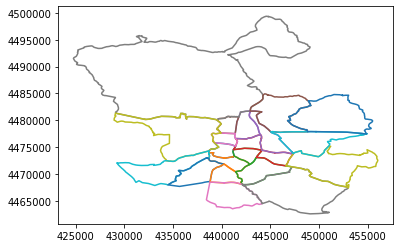

In [4]:
plt.figure()
for shape in sf.shapes():
    x = [i[0] for i in shape.points[:]]
    y = [i[1] for i in shape.points[:]]
    plt.plot(x,y)
plt.show()

In [5]:
import geopandas as gpd
# GeoDataFrame creation
poly = gpd.read_file("SHP_ETRS89/DISTRITOS.shp")
poly.head()


,NOMBRE,CODDISTRIT,SHAPE_area,SHAPE_len,geometry
0,Centro,1,5.231267e+06,10304.545144,"POLYGON ((441184.740 4473200.754, 441181.200 4..."
1,Arganzuela,2,6.466406e+06,12834.885747,"POLYGON ((440272.872 4472969.544, 440350.271 4..."
2,Retiro,3,5.465317e+06,9523.926778,"POLYGON ((443652.112 4473312.571, 443560.700 4..."
3,Salamanca,4,5.387252e+06,10862.998823,"POLYGON ((444075.165 4476611.812, 444057.794 4..."
4,Chamartín,5,9.170135e+06,13401.482255,"POLYGON ((442907.033 4481552.856, 442901.023 4..."


In [6]:
lista_distritos = poly.NOMBRE.tolist()
lista_geometry = poly.geometry.tolist()

In [7]:
points = poly.copy()
points.geometry = points['geometry'].centroid
points.crs =poly.crs
points.head()
points[points["NOMBRE"] == "Centro"]

,NOMBRE,CODDISTRIT,SHAPE_area,SHAPE_len,geometry
0,Centro,1,5.231267e+06,10304.545144,POINT (440165.384 4474316.010)


In [8]:
points.to_file('geoch_centroid.shp')

In [9]:
centroids = shapefile.Reader("Centroids/geoch_centroid.shp")

In [10]:
origin_x = 440165.384
origin_y = 4474316.010

In [11]:
nombres = points.NOMBRE.tolist()
x_lists = []
y_lists = []
for centroid in centroids.shapes():
    x = [i[0] for i in centroid.points[:]]
    y = [i[1] for i in centroid.points[:]]
    x_lists.append(x)
    y_lists.append(y)
centroides = list(zip(nombres,x_lists,y_lists))
centroides[0][1][0]

440165.3843573413

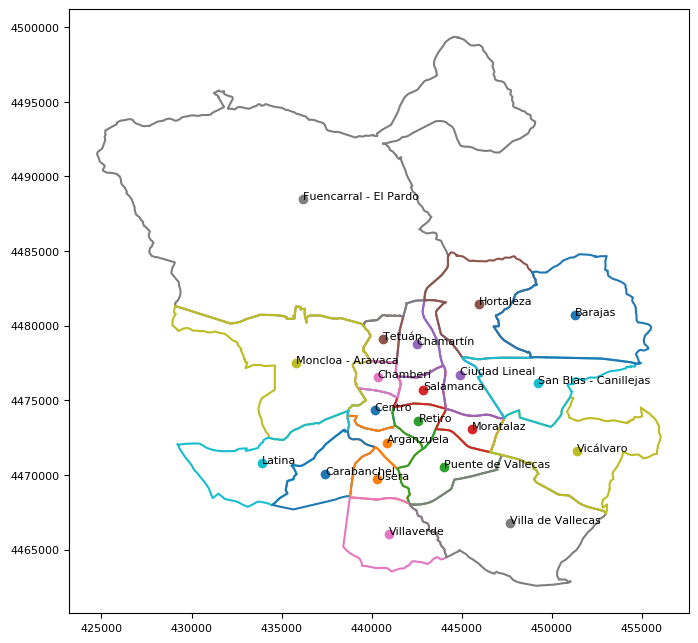

In [12]:
plt.figure(figsize=(8,8),dpi=100)
matplotlib.rcParams.update({'font.size': 8})
for shape in sf.shapes():
    x = [i[0] for i in shape.points[:]]
    y = [i[1] for i in shape.points[:]]
    plt.plot(x,y)
for x in centroides:
    plt.scatter(x[1][0],x[2][0])
    plt.text(x[1][0],x[2][0],x[0])
plt.show()

In [13]:
test_point = Point(0,0)

In [14]:
distritos_corrected = []
for shape in sf.shapes():
    x = [i[0] for i in shape.points[:]]
    y = [i[1] for i in shape.points[:]]
    new_x = []
    new_y = []
    for i in x:
        new_x.append(i-origin_x)
    for i in y:
        new_y.append(i-origin_y)
    merged_list = tuple(zip(new_x, new_y))  
    distritos_corrected.append(Polygon(merged_list))

In [15]:
centroides_corrected = []
for centroide in centroides:
    x = centroide[1][0] - origin_x
    y = centroide[2][0] - origin_y
    centroides_corrected.append(Point(x,y))

In [16]:
centroides_corrected

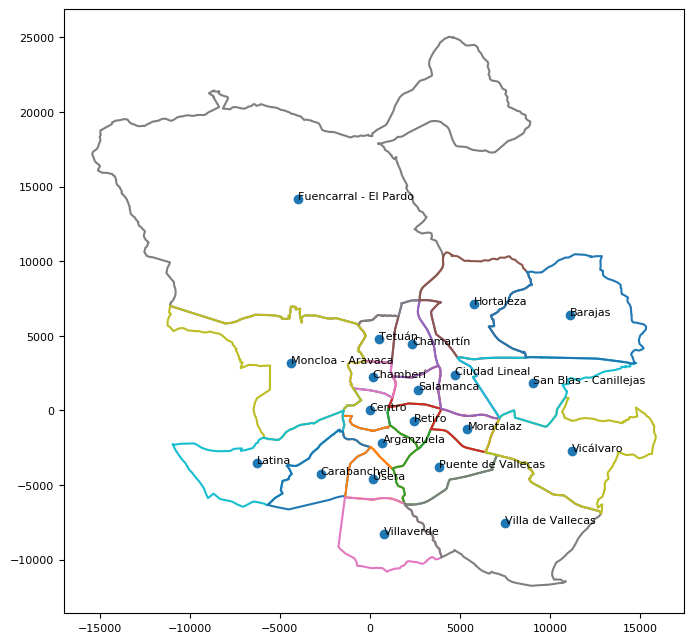

In [17]:
plt.figure(figsize=(8,8),dpi=100)
matplotlib.rcParams.update({'font.size': 8})

for distrito in distritos_corrected:
    x, y = distrito.exterior.coords.xy
    plt.plot(x,y)
x_centroides = [i.xy[0][0] for i in centroides_corrected]
y_centroides = [i.xy[1][0] for i in centroides_corrected]
plt.scatter(x_centroides,y_centroides)
for i in range(0,len(lista_distritos)):
    plt.text(x_centroides[i],y_centroides[i],lista_distritos[i])

plt.show()

In [18]:
def check_collision(point):
    collision_list = []
    for poly in distritos_corrected:
        collision_list.append(poly.contains(point))
    return collision_list

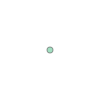

In [19]:
def gen_random_point(centroid,k):
    x = centroid.xy[0][0] + random.uniform(-1,1) * k
    y = centroid.xy[1][0] + random.uniform(-1,1) * k
    return Point(x,y)
gen_random_point(test_point,1)

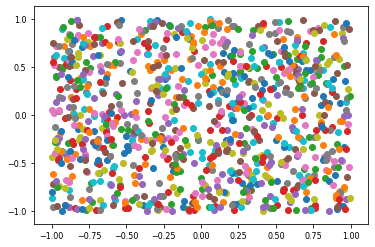

In [20]:
random_x = []
random_y = []
for i in range(0,1000):
    point = gen_random_point(test_point,1)
    plt.scatter(point.xy[0][0],point.xy[1][0])
plt.show()

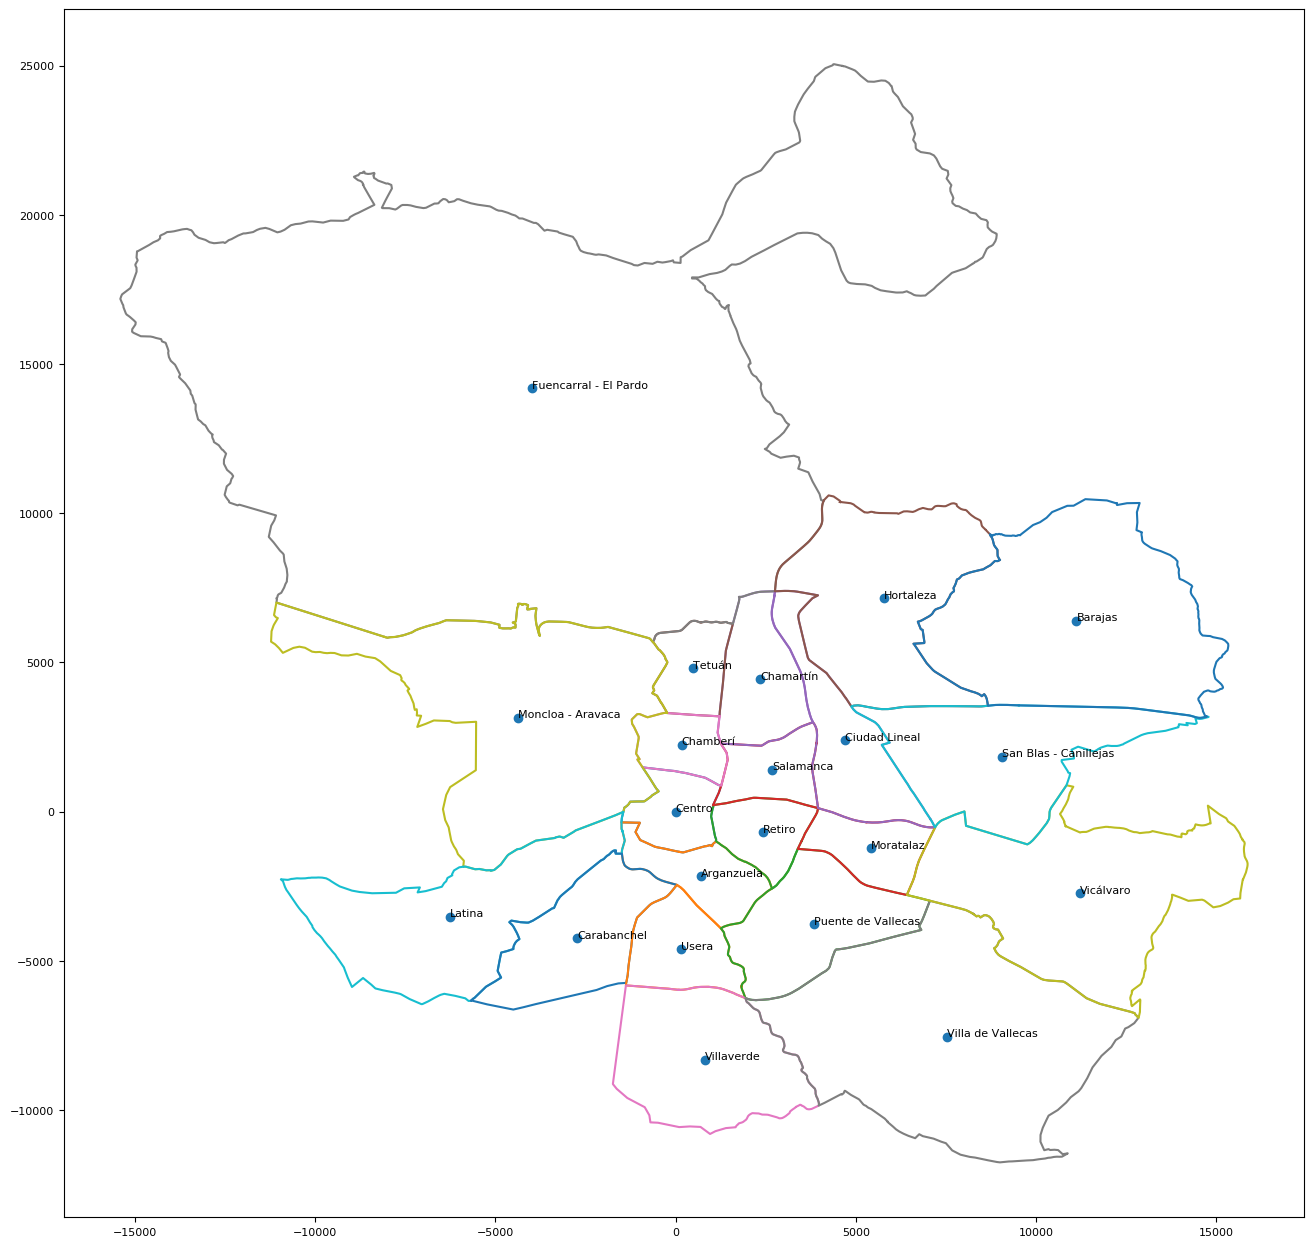

In [21]:
def plot_Madrid():
    plt.figure(figsize=(16,16),dpi=100)
    matplotlib.rcParams.update({'font.size': 8})

    for distrito in distritos_corrected:
        x, y = distrito.exterior.coords.xy
        plt.plot(x,y)
    x_centroides = [i.xy[0][0] for i in centroides_corrected]
    y_centroides = [i.xy[1][0] for i in centroides_corrected]
    plt.scatter(x_centroides,y_centroides)
    for i in range(0,len(lista_distritos)):
        plt.text(x_centroides[i],y_centroides[i],lista_distritos[i])
plot_Madrid()    

In [22]:
def gen_accident_coordinates(district):
    try:
        lista_distritos.index(district)
    except ValueError:
        index_distrito = 0
    else:
        index_distrito = lista_distritos.index(district)
    max_dist = 12000
    proposed_point = gen_random_point(centroides_corrected[index_distrito],max_dist)
    while check_collision(proposed_point)[index_distrito] == False:
        max_dist = max_dist/2
        proposed_point = gen_random_point(centroides_corrected[index_distrito],max_dist)
    return proposed_point

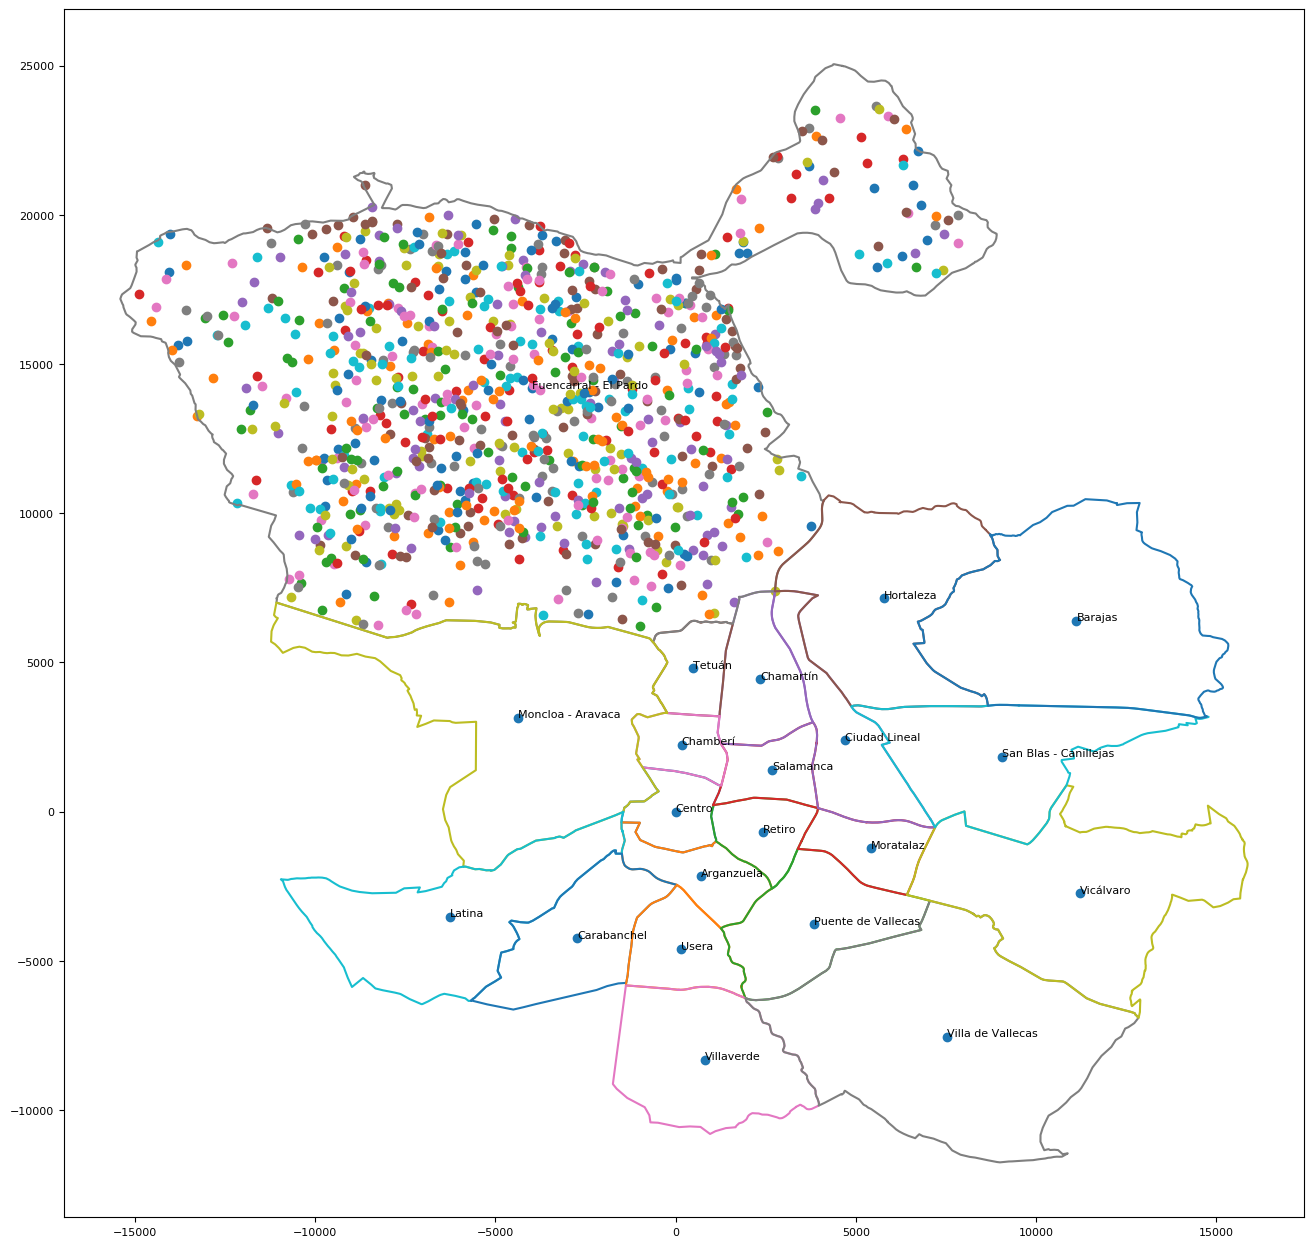

4.590955018997192


In [23]:
plot_Madrid()
start_time = time.time()
for i in range(0,1000):
    point = gen_accident_coordinates("Fuencarral - El Pardo")
    plt.scatter(point.xy[0][0],point.xy[1][0])
elapsed_time = time.time() - start_time
plt.show()
print(elapsed_time)

In [24]:
dataset = pd.read_csv("Samur_studied.csv")
dataset.drop(["Unnamed: 0"],axis =1,inplace=True)
dataset

,Año,Mes,Distrito,Hospital,Devuelto,Solicitud,Intervención,Dia de la semana,Tiempo de recorrido,Gravedad,IBC
0,2017,ENERO,CENTRO,Concepción (Fund. J. Díaz),False,2017-01-01 00:23:19,2017-01-01 00:28:59,6,0 days 00:05:40,2,0.0
1,2017,ENERO,CARABANCHEL,No derivado,False,2017-01-01 00:27:35,2017-01-01 00:35:44,6,0 days 00:08:09,3,256.0
2,2017,ENERO,SALAMANCA,No derivado,False,2017-01-01 00:47:26,2017-01-01 00:55:49,6,0 days 00:08:23,2,1191.0
3,2017,ENERO,CENTRO,Doce de Octubre,False,2017-01-01 00:55:13,2017-01-01 01:02:23,6,0 days 00:07:10,3,467.0
4,2017,ENERO,VILLA DE VALLECAS,No derivado,False,2017-01-01 01:07:11,2017-01-01 01:19:44,6,0 days 00:12:33,4,718.0
...,...,...,...,...,...,...,...,...,...,...,...
413830,2019,DICIEMBRE,HORTALEZA,Ramón y Cajal,False,2019-12-31 23:12:54,2019-12-31 23:20:13,1,0 days 00:07:19,1,238.0
413831,2019,DICIEMBRE,CHAMBERI,No derivado,False,2019-12-31 23:26:55,2019-12-31 23:31:16,1,0 days 00:04:21,2,841.0
413832,2019,DICIEMBRE,CHAMARTIN,No derivado,False,2019-12-31 23:28:26,2019-12-31 23:35:50,1,0 days 00:07:24,2,91.0
413833,2019,DICIEMBRE,LATINA,Central de la Defensa,False,2019-12-31 23:32:19,2019-12-31 23:37:39,1,0 days 00:05:20,2,233.0


In [25]:
dataset["Distrito"].unique() #Que bueno esto de que la Comunidad de Madrid no use los mismos nombres para sus distritos

array(['CENTRO', 'CARABANCHEL', 'SALAMANCA', 'VILLA DE VALLECAS',
       'TETUAN', 'VALLECAS PTE.', 'LATINA', 'MORATALAZ', 'VILLAVERDE',
       'SAN BLAS', 'CIUDAD LINEAL', 'MONCLOA', 'CHAMBERI', 'CHAMARTIN',
       'USERA', 'HORTALEZA', 'BARAJAS', 'ARGANZUELA', 'RETIRO',
       'FUENCARRAL', 'VICALVARO', 'FUERA TERMINO MUNICIPAL', 'POZUELO',
       'CARRETERAS Y CIRCUNVALACIONES', 'C.A.M.', 'LEGANES'], dtype=object)

In [26]:
lista_distritos

['Centro',
 'Arganzuela',
 'Retiro',
 'Salamanca',
 'Chamartín',
 'Tetuán',
 'Chamberí',
 'Fuencarral - El Pardo',
 'Moncloa - Aravaca',
 'Latina',
 'Carabanchel',
 'Usera',
 'Puente de Vallecas',
 'Moratalaz',
 'Ciudad Lineal',
 'Hortaleza',
 'Villaverde',
 'Villa de Vallecas',
 'Vicálvaro',
 'San Blas - Canillejas',
 'Barajas']

In [27]:
def random_district():
    return random.choice(lista_distritos)

In [28]:
district_translator = {'CENTRO':'Centro', 'CARABANCHEL':'Carabanchel', 'SALAMANCA':'Salamanca', 'VILLA DE VALLECAS':'Villa de Vallecas',
       'TETUAN':'Tetuán', 'VALLECAS PTE.':'Puente de Vallecas', 'LATINA':'Latina', 'MORATALAZ':'Moratalaz', 'VILLAVERDE':'Villaverde',
       'SAN BLAS':'San Blas - Canillejas', 'CIUDAD LINEAL':'Ciudad Lineal', 'MONCLOA': 'Moncloa - Aravaca', 'CHAMBERI':'Chamberí', 'CHAMARTIN':'Chamartín',
       'USERA':'Usera', 'HORTALEZA':'Hortaleza', 'BARAJAS':'Barajas', 'ARGANZUELA':'Arganzuela', 'RETIRO':'Retiro',
       'FUENCARRAL':'Fuencarral - El Pardo', 'VICALVARO':'Vicálvaro'}

In [29]:
print(district_translator.get('CARRETERAS Y CIRCUNVALACIONES',random_district()))

Barajas


In [30]:
x = dataset["Distrito"].apply(lambda x : district_translator.get(x))

In [31]:
dataset["Distrito"] = x

In [32]:
dataset["Mes"].unique()

array(['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO',
       'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE'],
      dtype=object)

In [33]:
truthtable = []
for x in dataset.iterrows():
    truthtable.append(x[1][2] in lista_distritos)
dataset = dataset[truthtable]

In [34]:
dataset = dataset[dataset["Distrito"] != np.nan]

In [148]:
dataset["Distrito"].unique()

array(['Centro', 'Carabanchel', 'Salamanca', 'Villa de Vallecas',
       'Tetuán', 'Puente de Vallecas', 'Latina', 'Moratalaz',
       'Villaverde', 'San Blas - Canillejas', 'Ciudad Lineal',
       'Moncloa - Aravaca', 'Chamberí', 'Chamartín', 'Usera', 'Hortaleza',
       'Barajas', 'Arganzuela', 'Retiro', 'Fuencarral - El Pardo',
       'Vicálvaro'], dtype=object)

In [175]:
start_time = time.time()
test_dataset = dataset[(dataset["Año"] == 2017) & (dataset["Mes"] == "ENERO")]
new_column = []
for distrito in test_dataset["Distrito"]:
    new_column.append(gen_accident_coordinates(distrito))
elapsed_time = time.time() - start_time
print(elapsed_time)

20.13889765739441


In [193]:
len(new_column)
dataset["Distrito"].unique()[20]

'Vicálvaro'

In [195]:
start_time = time.time() #14 minutos para generar 413835 puntos semialeatorios. Not bad....
for año in dataset["Año"].unique(): 
    temp_dataset = dataset[dataset["Año"] == año]
    for mes in dataset["Mes"].unique():
        temp_dataset_2 = temp_dataset[temp_dataset["Mes"] == mes]
        append_list = []
        for distrito in temp_dataset_2["Distrito"]:
            append_list.append(gen_accident_coordinates(distrito))
        temp_dataset_2["Coordenadas"] = append_list
        temp_dataset_2.to_csv("Datasets_con_coordenadas/SAMUR_Coordenadas_%s_%s.csv" % (año,mes))
elapsed_time = time.time() - start_time

/home/algadoc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Completado 2017 Chamberí
Completado 2017 Centro
Completado 2017 Carabanchel
Completado 2017 Moratalaz
Completado 2017 Carabanchel
Completado 2017 Arganzuela
Completado 2017 Chamberí
Completado 2017 Arganzuela
Completado 2017 Centro
Completado 2017 Villa de Vallecas
Completado 2017 Villaverde
Completado 2017 Centro
Completado 2018 Latina
Completado 2018 San Blas - Canillejas
Completado 2018 Carabanchel
Completado 2018 Tetuán
Completado 2018 Puente de Vallecas
Completado 2018 Villaverde
Completado 2018 Hortaleza
Completado 2018 Puente de Vallecas
Completado 2018 Centro
Completado 2018 Villaverde
Completado 2018 Ciudad Lineal
Completado 2018 Ciudad Lineal
Completado 2019 Tetuán
Completado 2019 Hortaleza
Completado 2019 Retiro
Completado 2019 Arganzuela
Completado 2019 Vicálvaro
Completado 2019 Moncloa - Aravaca
Completado 2019 Chamartín
Completado 2019 Arganzuela
Completado 2019 Vicálvaro
Completado 2019 Centro
Completado 2019 Puente de Vallecas
Completado 2019 Arganzuela


In [201]:
prev_dataset = pd.DataFrame()
for year in [2017,2018,2019]:
    for month in ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO',
       'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']:
        new_dataset = pd.read_csv("Datasets_con_coordenadas/SAMUR_Coordenadas_%s_%s.csv" % (year,month))
        prev_dataset = pd.concat([prev_dataset,new_dataset])
prev_dataset = prev_dataset.drop(["Unnamed: 0"], axis = 1)

In [206]:
prev_dataset.to_csv("Dataset_SAMUR.csv")

In [212]:
joblib.dump(lista_distritos,"Variables Geográficas/lista_distritos")
joblib.dump(distritos_corrected,"Variables Geográficas/distritos_corrected")
joblib.dump(centroides_corrected,"Variables Geográficas/centroides_corrected")

['Variables Geográficas/centroides_corrected']

['Variables Geográficas/plot_Madrid']

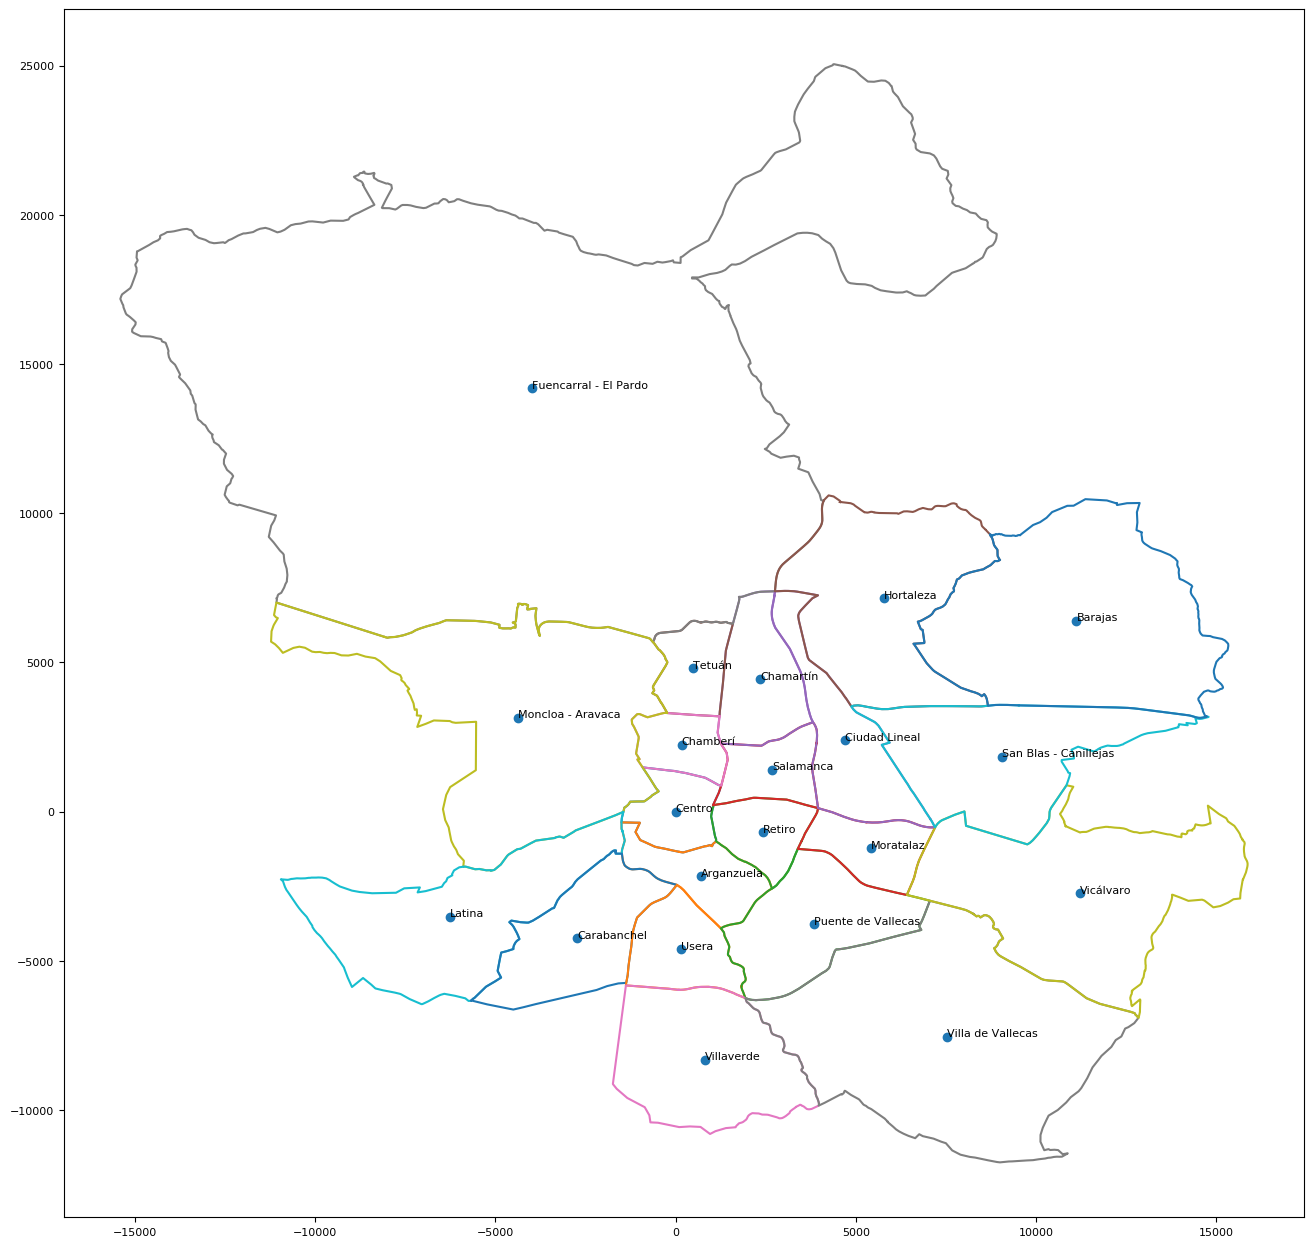